<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [3]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn

Cloning into 'deepul'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 254 (delta 46), reused 32 (delta 32), pack-reused 182
Receiving objects: 100% (254/254), 94.70 MiB | 10.57 MiB/s, done.
Resolving deltas: 100% (95/95), done.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=348f2b8f34ef423bc291568480999ff269b275d2ac78c458e57604f5947cb4a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-8mw1ekig/wheels/27/bf/c9/48d1e8588c449aa6503f321f5b6a686cc0c5417d66220cfdf9
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [44]:
from deepul.hw4_helper import *

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import torch
torch.random.seed()

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from tqdm import trange, tqdm_notebook, tqdm
from collections import OrderedDict
import torchvision.transforms as T
import math
from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR, LambdaLR

cuda


# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

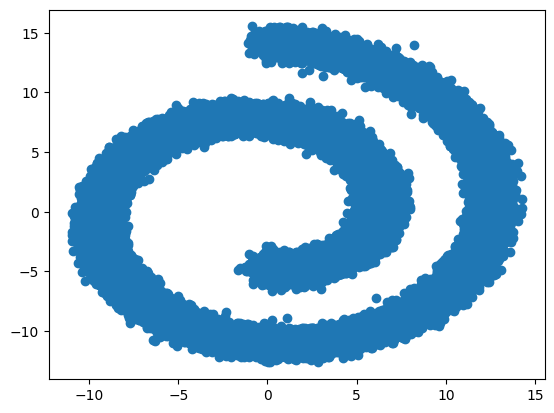

In [45]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [51]:
def train(epoch, model, optimizer, train_loader, scheduler=None):

    model.train()
    train_losses = []

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch}', unit='batch', dynamic_ncols=True, position=0, leave=True) as progress_bar:
        for i, x in enumerate(train_loader):
            # optimize discriminator
            x = x.to(device)
            loss = model.loss(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler(epoch, i)
            train_losses.append(loss.item())
            progress_bar.update(1)
            progress_bar.set_postfix(loss=f"Loss: {loss.item()}")
    return train_losses

def train_epochs(epochs, model, train_loader, test_loader, lr, scheduler=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [],[]
    for epoch in range(epochs):
        model.train()
        train_loss = train(epoch, model,optimizer,train_loader, None)
        train_losses += train_loss
        eval_loss = np.mean(evaluate(model,test_loader,device))
        test_losses.append(eval_loss)
        print(f"Epoch: {epoch}, Eval Loss: {eval_loss}")
        torch.save(model.state_dict(), "q1_model.pt")
        np.save("q1_train_losses.npy",np.array(train_losses))
        np.save("q1_test_losses.npy",np.array(test_losses))
    return train_losses, test_losses

def evaluate(model, dataloader, device):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for i,x in enumerate(dataloader):
            x = x.to(device)
            loss = model.loss(x)
            test_losses.append(loss.item())
    return test_losses

In [52]:
class DiffusionScheduler:
    def sample_timestep(self):
        """Samples a random timestep uniformly from the interval [0, 1]."""
        return np.random.uniform()
    def schedule(self, t):
        """Computes the noise schedule for a given timestep t using a cosine schedule."""
        alpha_t = np.cos(np.pi / 2 * t)
        sigma_t = np.sin(np.pi / 2 * t)
        return alpha_t, sigma_t
    def schedule_torch(self, t):
        """A torch-compatible version of the schedule method for tensor inputs."""
        alpha_t = torch.cos(np.pi / 2 * t)
        sigma_t = torch.sin(np.pi / 2 * t)
        return alpha_t, sigma_t

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super(MLP, self).__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

class ContinuousDiffusion(nn.Module):
    def __init__(self, input_size=3, n_hidden=4, hidden_size=64, output_size=2,data_mean=0, data_std=1):
        super(ContinuousDiffusion, self).__init__()
        self.scheduler = DiffusionScheduler()
        self.model = MLP(input_size, n_hidden, hidden_size, output_size)
        self.data_mean = data_mean
        self.data_std = data_std
    def forward(self, x, t=None):
        if t is None:
            timestep = self.scheduler.sample_timestep()
            timestep_tensor = torch.tensor(timestep, device=x.device).repeat(x.size(0), 1)
        else:
            timestep_tensor = t
        x_normalized = (x - self.data_mean) / self.data_std
        noise = torch.randn_like(x_normalized)
        alpha_t, sigma_t = self.scheduler.schedule_torch(timestep_tensor)
        #print(x_normalized.shape, alpha_t.shape,sigma_t.shape)
        x_t = alpha_t * x_normalized + sigma_t * noise
        noise_pred = self.model(torch.cat([x_t, timestep_tensor], dim=1))
        return noise_pred, noise
    def loss(self, x):
        noise_pred, noise = self(x)
        return nn.MSELoss()(noise_pred, noise)
    
    def sample(self, num_steps=100, device='cuda'):
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
        x = torch.randn((2000, 2), device=device)  # Starting from noise
        for i in range(num_steps):
            t = torch.tensor([ts[i]], dtype=torch.float32, device=device).repeat((x.shape[0],1))
            tm1 = torch.tensor([ts[i + 1]], dtype=torch.float32, device=device)
            eps_hat = self.model(torch.cat([x, t], dim=1))
            x = self.ddpm_update(x, eps_hat, t, tm1)
        return x
    
    def ddpm_update(self, x, eps_hat, t, tm1):
        alpha_t, sigma_t = self.scheduler.schedule_torch(t)
        alpha_tm1, sigma_tm1 = self.scheduler.schedule_torch(tm1)
        eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - (alpha_t / alpha_tm1) ** 2)
        epsilon_t = torch.randn_like(x)
        # Compute adjusted_sigma to avoid negative values under the square root
        adjusted_sigma = torch.clamp(sigma_tm1**2 - eta_t**2, min=0)
        sqrt_adjusted_sigma = torch.sqrt(adjusted_sigma)
        x_tm1 = alpha_tm1 * (x - sigma_t * eps_hat) / alpha_t + sqrt_adjusted_sigma * eps_hat + eta_t * epsilon_t
        return x_tm1

In [53]:
def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    # Init params
    epochs, lr  = 100, 1e-3
    all_samples = []

    # Noramlize and load data
    train_data = torch.tensor(train_data)
    test_data = torch.tensor(test_data)
    data_mean = train_data.mean(dim=0).to(device)
    data_std = train_data.std(dim=0).to(device)
    train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1024)
 
    # Create model
    model = ContinuousDiffusion(input_size=3, n_hidden=4, hidden_size=64, output_size=2, data_mean=data_mean,data_std=data_std).to(device)
    
    # Train
    train_losses, test_losses = train_epochs(epochs, model, train_loader, test_loader, lr, None)

    # Sample
    model.eval()
    for step in np.power(2, np.linspace(0, 9, 9)).astype(int):
        samples = model.sample(step,device)
        samples_rescaled = samples * data_std + data_mean
        all_samples.append(samples_rescaled.detach().cpu().numpy())
    all_samples = np.array(all_samples)
    return train_losses, test_losses, all_samples

Epoch 0:   0%|          | 0/98 [00:00<?, ?batch/s]

Epoch 0: 100%|██████████| 98/98 [00:00<00:00, 259.36batch/s, loss=Loss: 0.12640906870365143]


Epoch: 0, Eval Loss: 0.6210055708885193


Epoch 1: 100%|██████████| 98/98 [00:00<00:00, 261.79batch/s, loss=Loss: 0.8840243220329285]  


Epoch: 1, Eval Loss: 0.5053783625364303


Epoch 2: 100%|██████████| 98/98 [00:00<00:00, 289.26batch/s, loss=Loss: 0.761370062828064]   


Epoch: 2, Eval Loss: 0.44116583913564683


Epoch 3: 100%|██████████| 98/98 [00:00<00:00, 314.70batch/s, loss=Loss: 0.2231082022190094]  


Epoch: 3, Eval Loss: 0.4529808102175593


Epoch 4: 100%|██████████| 98/98 [00:00<00:00, 290.25batch/s, loss=Loss: 0.020173637196421623]


Epoch: 4, Eval Loss: 0.5751842737197876


Epoch 5: 100%|██████████| 98/98 [00:00<00:00, 298.76batch/s, loss=Loss: 0.42558059096336365] 


Epoch: 5, Eval Loss: 0.23788669649511576


Epoch 6: 100%|██████████| 98/98 [00:00<00:00, 249.73batch/s, loss=Loss: 0.41962388157844543]  


Epoch: 6, Eval Loss: 0.48020756654441354


Epoch 7: 100%|██████████| 98/98 [00:00<00:00, 277.11batch/s, loss=Loss: 0.02750643715262413] 


Epoch: 7, Eval Loss: 0.4897360369563103


Epoch 8: 100%|██████████| 98/98 [00:00<00:00, 288.24batch/s, loss=Loss: 0.9171842932701111]  


Epoch: 8, Eval Loss: 0.5074309557676315


Epoch 9: 100%|██████████| 98/98 [00:00<00:00, 272.94batch/s, loss=Loss: 0.03700908645987511]  


Epoch: 9, Eval Loss: 0.4878615697845817


Epoch 10: 100%|██████████| 98/98 [00:00<00:00, 269.91batch/s, loss=Loss: 0.0041631609201431274]


Epoch: 10, Eval Loss: 0.3560869336128235


Epoch 11: 100%|██████████| 98/98 [00:00<00:00, 272.01batch/s, loss=Loss: 0.09909360110759735]  


Epoch: 11, Eval Loss: 0.49751070570200684


Epoch 12: 100%|██████████| 98/98 [00:00<00:00, 281.92batch/s, loss=Loss: 0.005792779847979546]


Epoch: 12, Eval Loss: 0.3280450291931629


Epoch 13: 100%|██████████| 98/98 [00:00<00:00, 308.43batch/s, loss=Loss: 0.183033749461174]    


Epoch: 13, Eval Loss: 0.43182612098753453


Epoch 14: 100%|██████████| 98/98 [00:00<00:00, 309.12batch/s, loss=Loss: 0.7266205549240112]  


Epoch: 14, Eval Loss: 0.4515570212155581


Epoch 15: 100%|██████████| 98/98 [00:00<00:00, 285.59batch/s, loss=Loss: 0.7885629534721375]   


Epoch: 15, Eval Loss: 0.49180566519498825


Epoch 16: 100%|██████████| 98/98 [00:00<00:00, 282.89batch/s, loss=Loss: 0.8901866674423218]  


Epoch: 16, Eval Loss: 0.34970558397471907


Epoch 17: 100%|██████████| 98/98 [00:00<00:00, 283.67batch/s, loss=Loss: 0.6394563913345337]  


Epoch: 17, Eval Loss: 0.3068562462925911


Epoch 18: 100%|██████████| 98/98 [00:00<00:00, 242.28batch/s, loss=Loss: 0.00452819187194109] 


Epoch: 18, Eval Loss: 0.5013834238052368


Epoch 19: 100%|██████████| 98/98 [00:00<00:00, 294.42batch/s, loss=Loss: 0.7746224999427795]   


Epoch: 19, Eval Loss: 0.4777526207268238


Epoch 20: 100%|██████████| 98/98 [00:00<00:00, 317.23batch/s, loss=Loss: 0.3218502700328827]  


Epoch: 20, Eval Loss: 0.4778757978230715


Epoch 21: 100%|██████████| 98/98 [00:00<00:00, 317.38batch/s, loss=Loss: 0.7831422090530396]   


Epoch: 21, Eval Loss: 0.304177672136575


Epoch 22: 100%|██████████| 98/98 [00:00<00:00, 280.12batch/s, loss=Loss: 0.7345054149627686]  


Epoch: 22, Eval Loss: 0.4110341753810644


Epoch 23: 100%|██████████| 98/98 [00:00<00:00, 292.39batch/s, loss=Loss: 0.4228000342845917]  


Epoch: 23, Eval Loss: 0.3420512668788433


Epoch 24: 100%|██████████| 98/98 [00:00<00:00, 293.03batch/s, loss=Loss: 0.7569422125816345]  


Epoch: 24, Eval Loss: 0.2888984177261591


Epoch 25: 100%|██████████| 98/98 [00:00<00:00, 262.49batch/s, loss=Loss: 0.6995620131492615]  


Epoch: 25, Eval Loss: 0.3634563013911247


Epoch 26: 100%|██████████| 98/98 [00:00<00:00, 295.33batch/s, loss=Loss: 0.8215945959091187]  


Epoch: 26, Eval Loss: 0.40624668868258595


Epoch 27: 100%|██████████| 98/98 [00:00<00:00, 325.59batch/s, loss=Loss: 0.17995715141296387] 


Epoch: 27, Eval Loss: 0.6010031044483185


Epoch 28: 100%|██████████| 98/98 [00:00<00:00, 290.73batch/s, loss=Loss: 0.709520697593689]    


Epoch: 28, Eval Loss: 0.36998024955391884


Epoch 29: 100%|██████████| 98/98 [00:00<00:00, 245.69batch/s, loss=Loss: 0.26524418592453003] 


Epoch: 29, Eval Loss: 0.4389724204316735


Epoch 30: 100%|██████████| 98/98 [00:00<00:00, 270.51batch/s, loss=Loss: 0.6688343286514282]  


Epoch: 30, Eval Loss: 0.4139964188914746


Epoch 31: 100%|██████████| 98/98 [00:00<00:00, 251.66batch/s, loss=Loss: 0.40312331914901733]  


Epoch: 31, Eval Loss: 0.4907108698040247


Epoch 32: 100%|██████████| 98/98 [00:00<00:00, 267.19batch/s, loss=Loss: 0.7579655647277832]  


Epoch: 32, Eval Loss: 0.353632830362767


Epoch 33: 100%|██████████| 98/98 [00:00<00:00, 275.92batch/s, loss=Loss: 0.6718745827674866]   


Epoch: 33, Eval Loss: 0.41405608169734476


Epoch 34: 100%|██████████| 98/98 [00:00<00:00, 275.11batch/s, loss=Loss: 0.7412124276161194]  


Epoch: 34, Eval Loss: 0.6821988865733146


Epoch 35: 100%|██████████| 98/98 [00:00<00:00, 262.71batch/s, loss=Loss: 0.7233232855796814]   


Epoch: 35, Eval Loss: 0.42685940079391005


Epoch 36: 100%|██████████| 98/98 [00:00<00:00, 250.29batch/s, loss=Loss: 0.28084415197372437]  


Epoch: 36, Eval Loss: 0.3970135472714901


Epoch 37: 100%|██████████| 98/98 [00:00<00:00, 244.95batch/s, loss=Loss: 0.7979344129562378]  


Epoch: 37, Eval Loss: 0.37176176235079766


Epoch 38: 100%|██████████| 98/98 [00:00<00:00, 255.96batch/s, loss=Loss: 0.6820853352546692]  


Epoch: 38, Eval Loss: 0.4312526617199183


Epoch 39: 100%|██████████| 98/98 [00:00<00:00, 237.61batch/s, loss=Loss: 0.7252797484397888]  


Epoch: 39, Eval Loss: 0.38427784545347093


Epoch 40: 100%|██████████| 98/98 [00:00<00:00, 254.48batch/s, loss=Loss: 0.31751853227615356]  


Epoch: 40, Eval Loss: 0.2834820171818137


Epoch 41: 100%|██████████| 98/98 [00:00<00:00, 234.27batch/s, loss=Loss: 0.572475016117096]    


Epoch: 41, Eval Loss: 0.4321032978594303


Epoch 42: 100%|██████████| 98/98 [00:00<00:00, 281.68batch/s, loss=Loss: 0.25872039794921875]  


Epoch: 42, Eval Loss: 0.1602188219781965


Epoch 43: 100%|██████████| 98/98 [00:00<00:00, 262.78batch/s, loss=Loss: 1.049450159072876]    


Epoch: 43, Eval Loss: 0.4220167454332113


Epoch 44: 100%|██████████| 98/98 [00:00<00:00, 255.46batch/s, loss=Loss: 0.37258413434028625]  


Epoch: 44, Eval Loss: 0.4233500549569726


Epoch 45: 100%|██████████| 98/98 [00:00<00:00, 247.26batch/s, loss=Loss: 0.6645841598510742]   


Epoch: 45, Eval Loss: 0.467784172296524


Epoch 46: 100%|██████████| 98/98 [00:00<00:00, 215.09batch/s, loss=Loss: 0.7412869930267334]   


Epoch: 46, Eval Loss: 0.44897782132029534


Epoch 47: 100%|██████████| 98/98 [00:00<00:00, 201.78batch/s, loss=Loss: 0.37843072414398193]  


Epoch: 47, Eval Loss: 0.5028608739376068


Epoch 48: 100%|██████████| 98/98 [00:00<00:00, 226.06batch/s, loss=Loss: 0.015303822234272957]


Epoch: 48, Eval Loss: 0.561893417686224


Epoch 49: 100%|██████████| 98/98 [00:00<00:00, 258.47batch/s, loss=Loss: 0.5495519042015076]   


Epoch: 49, Eval Loss: 0.41055193170905113


Epoch 50: 100%|██████████| 98/98 [00:00<00:00, 251.18batch/s, loss=Loss: 0.04559655860066414] 


Epoch: 50, Eval Loss: 0.525093075633049


Epoch 51: 100%|██████████| 98/98 [00:00<00:00, 251.05batch/s, loss=Loss: 0.6756330728530884]   


Epoch: 51, Eval Loss: 0.5335367649793625


Epoch 52: 100%|██████████| 98/98 [00:00<00:00, 246.02batch/s, loss=Loss: 0.6335855722427368]  


Epoch: 52, Eval Loss: 0.2509925987571478


Epoch 53: 100%|██████████| 98/98 [00:00<00:00, 228.06batch/s, loss=Loss: 0.7877791523933411]   


Epoch: 53, Eval Loss: 0.3402510153129697


Epoch 54: 100%|██████████| 98/98 [00:00<00:00, 257.36batch/s, loss=Loss: 0.6843081712722778]   


Epoch: 54, Eval Loss: 0.47694710523355754


Epoch 55: 100%|██████████| 98/98 [00:00<00:00, 247.35batch/s, loss=Loss: 0.1790691465139389]   


Epoch: 55, Eval Loss: 0.3785818134434521


Epoch 56: 100%|██████████| 98/98 [00:00<00:00, 281.13batch/s, loss=Loss: 0.21331919729709625]  


Epoch: 56, Eval Loss: 0.3636950934305787


Epoch 57: 100%|██████████| 98/98 [00:00<00:00, 270.61batch/s, loss=Loss: 0.185049906373024]    


Epoch: 57, Eval Loss: 0.540765792131424


Epoch 58: 100%|██████████| 98/98 [00:00<00:00, 257.66batch/s, loss=Loss: 0.6860545873641968]   


Epoch: 58, Eval Loss: 0.5465426668524742


Epoch 59: 100%|██████████| 98/98 [00:00<00:00, 248.77batch/s, loss=Loss: 0.8127946257591248]  


Epoch: 59, Eval Loss: 0.5036075288429857


Epoch 60: 100%|██████████| 98/98 [00:00<00:00, 262.49batch/s, loss=Loss: 0.8589597344398499]   


Epoch: 60, Eval Loss: 0.4722380381077528


Epoch 61: 100%|██████████| 98/98 [00:00<00:00, 219.24batch/s, loss=Loss: 0.26096978783607483]  


Epoch: 61, Eval Loss: 0.3742006864864379


Epoch 62: 100%|██████████| 98/98 [00:00<00:00, 255.93batch/s, loss=Loss: 0.5912061333656311]   


Epoch: 62, Eval Loss: 0.4594441942870617


Epoch 63: 100%|██████████| 98/98 [00:00<00:00, 261.57batch/s, loss=Loss: 0.035454414784908295] 


Epoch: 63, Eval Loss: 0.3421786429360509


Epoch 64: 100%|██████████| 98/98 [00:00<00:00, 216.25batch/s, loss=Loss: 0.012854166328907013] 


Epoch: 64, Eval Loss: 0.5019812129437924


Epoch 65: 100%|██████████| 98/98 [00:00<00:00, 256.95batch/s, loss=Loss: 0.08875714242458344] 


Epoch: 65, Eval Loss: 0.5583508417010308


Epoch 66: 100%|██████████| 98/98 [00:00<00:00, 248.31batch/s, loss=Loss: 0.6790576577186584]   


Epoch: 66, Eval Loss: 0.4474324230104685


Epoch 67: 100%|██████████| 98/98 [00:00<00:00, 251.33batch/s, loss=Loss: 0.01032250840216875]  


Epoch: 67, Eval Loss: 0.526603324431926


Epoch 68: 100%|██████████| 98/98 [00:00<00:00, 247.27batch/s, loss=Loss: 0.19203558564186096]  


Epoch: 68, Eval Loss: 0.39709780090488495


Epoch 69: 100%|██████████| 98/98 [00:00<00:00, 241.29batch/s, loss=Loss: 0.11592972278594971] 


Epoch: 69, Eval Loss: 0.40118467137217523


Epoch 70: 100%|██████████| 98/98 [00:00<00:00, 256.93batch/s, loss=Loss: 0.5082162022590637]  


Epoch: 70, Eval Loss: 0.6043258905410767


Epoch 71: 100%|██████████| 98/98 [00:00<00:00, 270.43batch/s, loss=Loss: 0.03343367949128151] 


Epoch: 71, Eval Loss: 0.39478315860033036


Epoch 72: 100%|██████████| 98/98 [00:00<00:00, 254.38batch/s, loss=Loss: 0.29292353987693787]  


Epoch: 72, Eval Loss: 0.49404350072145464


Epoch 73: 100%|██████████| 98/98 [00:00<00:00, 249.77batch/s, loss=Loss: 0.6190029382705688]   


Epoch: 73, Eval Loss: 0.5033350296318531


Epoch 74: 100%|██████████| 98/98 [00:00<00:00, 271.04batch/s, loss=Loss: 0.7217624187469482]   


Epoch: 74, Eval Loss: 0.34867862118408083


Epoch 75: 100%|██████████| 98/98 [00:00<00:00, 272.24batch/s, loss=Loss: 0.8628997802734375]   


Epoch: 75, Eval Loss: 0.46620539054274557


Epoch 76: 100%|██████████| 98/98 [00:00<00:00, 228.11batch/s, loss=Loss: 0.4526774287223816]  


Epoch: 76, Eval Loss: 0.5413659669458866


Epoch 77: 100%|██████████| 98/98 [00:00<00:00, 252.22batch/s, loss=Loss: 0.21563643217086792]  


Epoch: 77, Eval Loss: 0.45286125540733335


Epoch 78: 100%|██████████| 98/98 [00:00<00:00, 245.10batch/s, loss=Loss: 0.2324291467666626]   


Epoch: 78, Eval Loss: 0.4716380946338177


Epoch 79: 100%|██████████| 98/98 [00:00<00:00, 236.96batch/s, loss=Loss: 0.39804527163505554]  


Epoch: 79, Eval Loss: 0.386786032281816


Epoch 80: 100%|██████████| 98/98 [00:00<00:00, 228.88batch/s, loss=Loss: 0.6515383720397949]   


Epoch: 80, Eval Loss: 0.326171088591218


Epoch 81: 100%|██████████| 98/98 [00:00<00:00, 261.44batch/s, loss=Loss: 0.011686860583722591] 


Epoch: 81, Eval Loss: 0.351821475988254


Epoch 82: 100%|██████████| 98/98 [00:00<00:00, 229.72batch/s, loss=Loss: 0.002279657870531082] 


Epoch: 82, Eval Loss: 0.5614528015255928


Epoch 83: 100%|██████████| 98/98 [00:00<00:00, 232.57batch/s, loss=Loss: 0.5730014443397522]   


Epoch: 83, Eval Loss: 0.37247976516373454


Epoch 84: 100%|██████████| 98/98 [00:00<00:00, 259.58batch/s, loss=Loss: 0.06798166781663895] 


Epoch: 84, Eval Loss: 0.4478775657713413


Epoch 85: 100%|██████████| 98/98 [00:00<00:00, 241.77batch/s, loss=Loss: 0.5572301149368286]   


Epoch: 85, Eval Loss: 0.4682720899581909


Epoch 86: 100%|██████████| 98/98 [00:00<00:00, 250.25batch/s, loss=Loss: 0.2652861177921295]   


Epoch: 86, Eval Loss: 0.4302788907662034


Epoch 87: 100%|██████████| 98/98 [00:00<00:00, 253.31batch/s, loss=Loss: 0.08565754443407059]  


Epoch: 87, Eval Loss: 0.4486943859606981


Epoch 88: 100%|██████████| 98/98 [00:00<00:00, 223.09batch/s, loss=Loss: 0.02542565017938614]  


Epoch: 88, Eval Loss: 0.35246532801538705


Epoch 89: 100%|██████████| 98/98 [00:00<00:00, 248.37batch/s, loss=Loss: 0.5700055360794067]   


Epoch: 89, Eval Loss: 0.29612106960266826


Epoch 90: 100%|██████████| 98/98 [00:00<00:00, 274.23batch/s, loss=Loss: 0.21939021348953247] 


Epoch: 90, Eval Loss: 0.40444299653172494


Epoch 91: 100%|██████████| 98/98 [00:00<00:00, 260.64batch/s, loss=Loss: 0.07831189036369324]  


Epoch: 91, Eval Loss: 0.37915606424212456


Epoch 92: 100%|██████████| 98/98 [00:00<00:00, 257.03batch/s, loss=Loss: 0.6539353728294373]   


Epoch: 92, Eval Loss: 0.44053841680288314


Epoch 93: 100%|██████████| 98/98 [00:00<00:00, 261.70batch/s, loss=Loss: 0.3923538029193878]   


Epoch: 93, Eval Loss: 0.6517444223165512


Epoch 94: 100%|██████████| 98/98 [00:00<00:00, 229.42batch/s, loss=Loss: 0.3328673243522644]   


Epoch: 94, Eval Loss: 0.5136523227207362


Epoch 95: 100%|██████████| 98/98 [00:00<00:00, 257.49batch/s, loss=Loss: 0.46132391691207886]  


Epoch: 95, Eval Loss: 0.37618752783164383


Epoch 96: 100%|██████████| 98/98 [00:00<00:00, 248.11batch/s, loss=Loss: 0.7830930352210999]   


Epoch: 96, Eval Loss: 0.5440281527116895


Epoch 97: 100%|██████████| 98/98 [00:00<00:00, 222.88batch/s, loss=Loss: 0.6605963110923767]  


Epoch: 97, Eval Loss: 0.4016747448593378


Epoch 98: 100%|██████████| 98/98 [00:00<00:00, 242.13batch/s, loss=Loss: 0.6831170320510864]   


Epoch: 98, Eval Loss: 0.4347412593662739


Epoch 99: 100%|██████████| 98/98 [00:00<00:00, 227.28batch/s, loss=Loss: 0.5050415992736816]  


Epoch: 99, Eval Loss: 0.36471560029312966
Final Test Loss: 0.3647


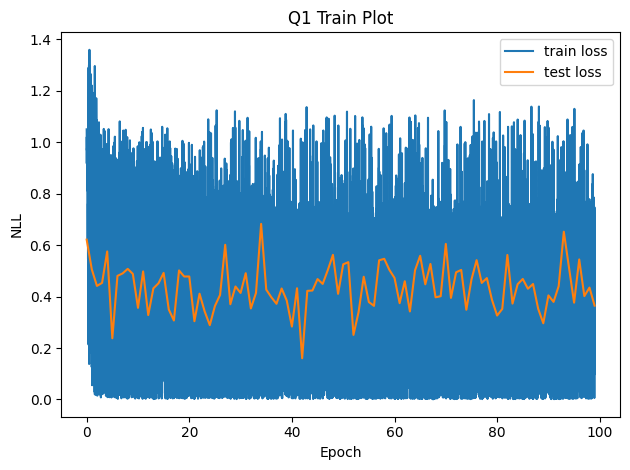

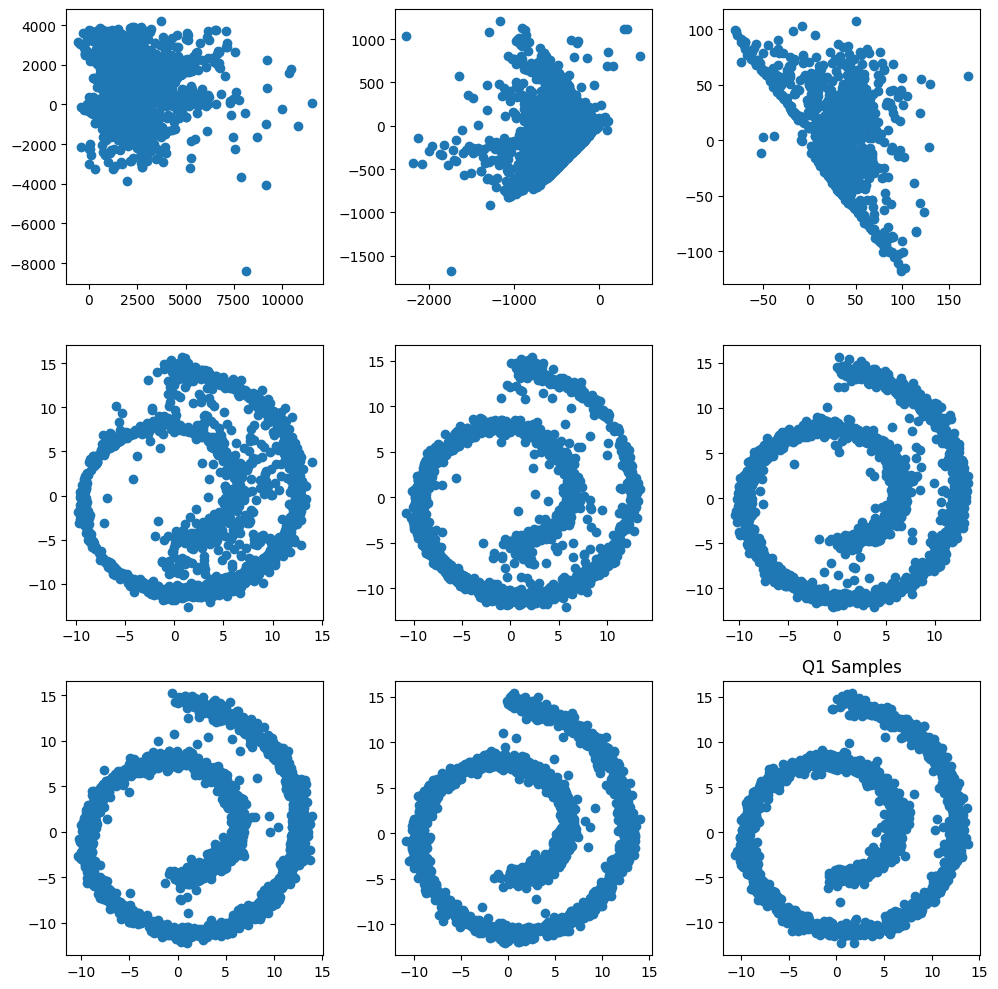

In [54]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


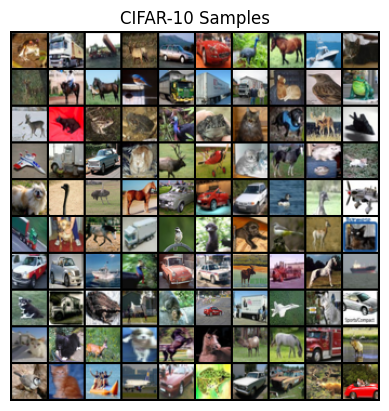

In [24]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
   # Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [68]:
""" 
We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. 
We provide the following pseudocode for each part of the model:
"""
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=np.float32) / half)
    args = timesteps[:, None].cpu().float() * freqs[None]
    # freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=np.float32) / half)
    # args = timesteps[:, None].astype(np.float32) * freqs[None, :]
    embedding = torch.cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = torch.cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)
    
    def forward(self, x):
        # Given x
        return self.conv2d(x)

class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels, in_channels, 3, padding=1)
    
    def forward(self, x):
        # Given x
        x = F.interpolate(x, scale_factor=2)
        x = self.conv2d(x)
        return x

from torch.optim.lr_scheduler import _LRScheduler, CosineAnnealingLR, LambdaLR

class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, initial_lr, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.initial_lr = initial_lr
        super(WarmupScheduler, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            lr = self.initial_lr * (self.last_epoch / self.warmup_steps)
        else:
            lr = self.initial_lr
        return [lr for _ in self.optimizer.param_groups]


In [69]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.temb_channels = temb_channels

    def forward(self, x, temb):
        # Given x, temb
        h = nn.Conv2d(self.in_channels, self.out_channels, 3, padding=1)(x)
        h = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)(h)
        h = nn.SiLU()(h)
        
        temb = nn.inear(self.temb_channels, self.out_channels)(temb)
        h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
        
        h = nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)(h)
        h = nn.GroupNorm(num_groups=8, num_channels=self.out_channels)(h)
        h = nn.SiLU()(h)
        
        if self.in_channels != self.out_channels:
            x = nn.Conv2d(self.in_channels, self.out_channels, 1)(x)
        return x + h
    
class UNet(nn.Module):
    """
    UNet architecture as described, incorporating time-step embeddings.
    """
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super().__init__()
        # Time embedding channels
        temb_channels = hidden_dims[0] * 4
        self.temb_layers = nn.Sequential(
            nn.Linear(hidden_dims[0], temb_channels),
            nn.SiLU(),
            nn.Linear(temb_channels, temb_channels)
        )
        # Initial convolution to match the first hidden dimension size.
        self.initial_conv = nn.Conv2d(in_channels, hidden_dims[0], kernel_size=3, padding=1)
        # Constructing downsample and upsample blocks
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        # Middle blocks that don't change spatial dimensions.
        self.middle_block1 = ResidualBlock(hidden_dims[-1], hidden_dims[-1], temb_channels)
        self.middle_block2 = ResidualBlock(hidden_dims[-1], hidden_dims[-1], temb_channels)
        # Building the downsample pathway
        prev_ch = hidden_dims[0]
        self.down_block_chans = [prev_ch]
        for dim in hidden_dims:
            for _ in range(blocks_per_dim):
                self.down_blocks.append(ResidualBlock(prev_ch, dim, temb_channels))
                prev_ch = dim
                self.down_block_chans.append(prev_ch)
            if dim != hidden_dims[-1]:
                self.down_blocks.append(Downsample(prev_ch))
                self.down_block_chans.append(prev_ch)
        # Building the upsample pathway
        for i,dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(blocks_per_dim + 1):
                dch = self.down_block_chans.pop()
                self.up_blocks.append(ResidualBlock(prev_ch + dch, dim, temb_channels))  # Note the dim*2 due to concatenation
                prev_ch = dim
                if i and j == blocks_per_dim:
                    self.up_blocks.append(Upsample(prev_ch))
        # Final normalization and convolution to output the same channels as input
        self.final_norm = nn.GroupNorm(num_groups=8, num_channels=hidden_dims[0])
        self.final_conv = nn.Conv2d(hidden_dims[0], in_channels, kernel_size=3, padding=1)
    def forward(self, x, t):
        # Time-step embedding
        temb = self.temb_layers(timestep_embedding(t, self.temb_layers[0].in_features)).squeeze(1)
        # Initial processing
        h = self.initial_conv(x)
        hs = [h]
        # Downsample pathway
        for block in self.down_blocks:
            # if isinstance(block, Downsample):
            #       # Save skip connection before downsampling
            h = block(h, temb) if isinstance(block, ResidualBlock) else block(h)
            hs.append(h)
        # print(len(hs))
        # assert False
        # Middle blocks
        h = self.middle_block1(h, temb)
        h = self.middle_block2(h, temb)
        # Upsample pathway
        for block in self.up_blocks:
            # print(h.shape)
            if isinstance(block, Upsample):
                h = block(h)
            else:
                # if h.size(2) != hs[-1].size(2) or h.size(3) != hs[-1].size(3):
                #     h = F.interpolate(h, size=(hs[-1].size(2), hs[-1].size(3)), mode='nearest')
                hsd =  hs.pop()
                # print(h.shape,hsd.shape)
                h = torch.cat([h,hsd], dim=1)  # [512, 1024, 3, 3], expected input[1024, 768, 8, 8]
                h = block(h, temb)
        # Final layers
        h = self.final_norm(h)
        h = F.silu(h)
        return self.final_conv(h)

class CifarDiffusion(nn.Module):
    def __init__(self, in_channels=3, hidden_dims=[64, 128, 256, 512], blocks_per_dim=2, data_mean=0.5, data_std=0.5):
        super(CifarDiffusion, self).__init__()
        # Adjusting for a more typical setup for CIFAR-10 with a U-Net having multiple layers of hidden dimensions
        self.model = UNet(in_channels=in_channels, hidden_dims=hidden_dims, blocks_per_dim=blocks_per_dim)
        self.scheduler = DiffusionScheduler()
        self.data_mean = torch.tensor(data_mean, dtype=torch.float32)
        self.data_std = torch.tensor(data_std, dtype=torch.float32)
    def forward(self, x, t=None):
        # Normalize input
        x_normalized = (x - self.data_mean) / self.data_std
        # Compute timestep embedding
        if t == None:
            t = torch.rand(x.size(0), 1).to(x.device)
        # Predict noise with UNet
        alpha_t, sigma_t = self.scheduler.schedule_torch(t)
        noise = torch.randn_like(x)
        x_t = alpha_t.view(-1, 1, 1, 1).to(x.device) * x_normalized + sigma_t.view(-1, 1, 1, 1).to(x.device) * noise.to(x.device)
        noise_pred = self.model(x_t, t)
        return noise_pred
    def loss(self, x):
        noise = torch.randn_like(x)
        noise_pred = self(x)
        return nn.MSELoss()(noise_pred, noise)
    def sample(self, num_steps=100, device='cuda'):
        self.to(device)
        ts = np.linspace(1 - 1e-4, 1e-4, num_steps + 1)
        x = torch.randn((2000, 3, 32, 32), device=device)*2-1  # Adjusted for CIFAR-10 dimensions
        for i in range(num_steps):
            t = torch.tensor([ts[i]], dtype=torch.float32, device=device).repeat((x.shape[0], 1))
            tm1 = torch.tensor([ts[i + 1]], dtype=torch.float32, device=device)
            eps_hat = self(x, t)
            x = self.ddpm_update(x, eps_hat, t, tm1)
        return x
    def ddpm_update(self, x, eps_hat, t, tm1):
        alpha_t, sigma_t = self.scheduler.schedule_torch(t)
        alpha_tm1, sigma_tm1 = self.scheduler.schedule_torch(tm1)
        eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - (alpha_t / alpha_tm1) ** 2)
        epsilon_t = torch.randn_like(x)
        adjusted_sigma = torch.clamp(sigma_tm1**2 - eta_t**2, min=0)
        sqrt_adjusted_sigma = torch.sqrt(adjusted_sigma)
        x_tm1 = alpha_tm1 * (x - sigma_t * eps_hat) / alpha_t + sqrt_adjusted_sigma * eps_hat + eta_t * epsilon_t
        return x_tm1

class WarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, initial_lr, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.initial_lr = initial_lr
        super(WarmupScheduler, self).__init__(optimizer, last_epoch)
    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            lr = self.initial_lr * (self.last_epoch / self.warmup_steps)
        else:
            lr = self.initial_lr
        return [lr for _ in self.optimizer.param_groups]

In [70]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """
    train_data = torch.tensor(train_data, dtype=torch.float32).permute(0,3,1,2) #(10000, 3, 32, 32)
    test_data = torch.tensor(test_data, dtype=torch.float32).permute(0,3,1,2) #(10000, 3, 32, 32)
    train_data = train_data*2-1
    test_data = test_data*2-1
    data_mean = train_data.mean(dim=0).to(device)
    data_std = train_data.std(dim=0).to(device)
    # print(data_mean.shape)
    # assert False
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=256)
    train_losses, test_losses, all_samples = [],[],[]
    EPOCHS = 60
    LR=0.001
    model = CifarDiffusion(in_channels=3, hidden_dims=[64, 128, 256, 512], blocks_per_dim=2, data_mean=data_mean, data_std = data_std).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    TOTAL_STEPS = EPOCHS * len(train_loader)
    WARMUP_STEPS = TOTAL_STEPS // 10
    scheduler_warmup = WarmupScheduler(optimizer, warmup_steps=WARMUP_STEPS, initial_lr=LR)
    scheduler_cosine = CosineAnnealingLR(optimizer, T_max=TOTAL_STEPS - WARMUP_STEPS, eta_min=0)
    def scheduler_step(epoch, batch_idx):
      global_step = epoch * len(train_loader) + batch_idx
      if global_step <= WARMUP_STEPS:
          scheduler_warmup.step()
      else:
          scheduler_cosine.step(global_step - WARMUP_STEPS)
    for epoch in range(EPOCHS):
      model.train()
      train_loss = train(epoch, model,optimizer,train_loader,device, scheduler_step)
      train_losses += train_loss
      eval_loss = np.mean(evaluate(model,test_loader,device))
      test_losses.append(eval_loss)
      print(f"Epoch: {epoch}, Eval Loss: {eval_loss}")
      torch.save(model.state_dict(), "q2_model_alt.pt")
      np.save("q2_train_losses_alt.npy",np.array(train_losses))
      np.save("q2_test_losses_alt.npy",np.array(test_losses))
      train_losses = np.load("q2_train_losses.npy")
      test_losses = np.load("q2_test_losses.npy")
      model.load_state_dict(torch.load("q2_model.pt"))
      model.eval()
      with torch.no_grad():
        for diff_steps in np.power(2, np.linspace(0, 9, 9)).astype(int):
            samples = model.sample(diff_steps,device)
            samples_rescaled = samples * data_std + data_mean
            all_samples.append(samples_rescaled.detach().cpu().numpy())
        all_samples = np.array(all_samples)
      return train_losses, test_losses, samples

In [71]:
q2_save_results(q2)

Files already downloaded and verified
Files already downloaded and verified


: 

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


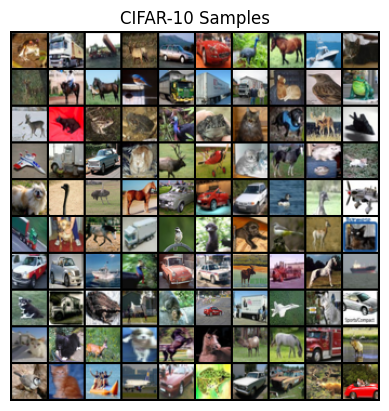

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [ ]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In [159]:
@property
def latent_shape(self):
    """Size of the encoded representation"""
    return [0, 0, 0]

def encode(self, x: np.ndarray) -> np.ndarray:
    """Encode an image x. Note: Channel dim is in dim 1
    Args:
        x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
    Returns:
        np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
    """
def decode(self, z: np.ndarray) -> np.ndarray:
    """Decode an encoded image.
    Args:
        z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
    Returns:
        np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
    """


In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [166]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """
    scale_factor = 0
    # Normalize data between [-1,1]
    images = 2 * images - 1   
    print(vae)
    # Fee images to VAE
    autoencoded_images = vae(images)
    assert(images.max() <= 1 and images.max() <= 1 and images.min() >= -1 and images.min() >= -1)
    autoencoded_images = np.array()
    return autoencoded_images, scale_factor

In [167]:
q3a_save_results(q3_a)

Files already downloaded and verified
Files already downloaded and verified
VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResidualBlock(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): ResidualBlock(
      (net): Sequential(
        (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(256, 256, kernel

RuntimeError: Given groups=1, weight of size [256, 3, 4, 4], expected input[1000, 32, 32, 3] to have 3 channels, but got 32 channels instead

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [ ]:
import math
from dataclasses import dataclass
import time
import torch
import torch.nn as nn
from torch.nn import functional as F


@dataclass
class TransformerConfig:
    vocab_size: int
    block_size: int
    n_layer: int = 2
    n_head: int = 4
    n_embd: int = 128


class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()

        # feature projections
        self.kqv_projection = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        

    def forward(self, x, k_cache=None, v_cache=None):
        B, T, C = x.size()  

        # calculate q, k v
        q, k, v = self.kqv_projection(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        if k_cache is not None:
            assert v_cache is not None
            assert T == 1
            # concat previous cache with new k, v
            v = torch.cat([v_cache, v], dim=2) # (B, nh, 1 + T', hs)
            k = torch.cat([k_cache, k], dim=2) # (B, nh, 1 + T', hs)
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # (B, nh, 1, 1 + T')
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))

        att = F.softmax(att, dim=-1)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        return self.proj(y), k, v


class Block(nn.Module):
    """Transfromer Block"""
    
    def __init__(self, config):
        super().__init__()
        self.ln = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        
        self.mlp_sequence = nn.Sequential(
            nn.LayerNorm(config.n_embd),
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
        )

    def forward(self, x, k_cache=None, v_cache=None):
        _x = x
        x, k, v = self.attn(self.ln(x), k_cache, v_cache)
        x = _x + x
        x = x + self.mlp_sequence(x)
        return x, k, v


class Transformer(nn.Module):
    """Simple Transformer"""

    def __init__(self, config: TransformerConfig):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.token_embeddings = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embeddings = nn.Embedding(config.block_size, config.n_embd)
        self.transformer_blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.layer_norm = nn.LayerNorm(config.n_embd)

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, start_idx=0, k_cache=None, v_cache=None):
        device = idx.device
        b, t = idx.size()
        assert (t <= self.block_size)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) + start_idx  

        tok_emb = self.token_embeddings(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.position_embeddings(pos)  # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb

        k_s = []
        v_s = []
        for idx, block in enumerate(self.transformer_blocks):
            if k_cache is not None:
                assert v_cache is not None
                k_i, v_i = k_cache[idx], v_cache[idx]
            else:
                k_i, v_i = None, None 
            x, k, v = block(x, k_i, v_i)
            k_s.append(k)
            v_s.append(v)

        logits = self.lm_head(self.layer_norm(x))
        return logits, k_s, v_s

    def loss(self, x):
        x_in, targets = x[:, :-1], x[:, 1:] # make target a shifted version of the original
        logits, _, _ = self(x_in)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1
        )
        return loss

    @torch.no_grad()
    def generate(
        self, idx, max_new_tokens=None, temperature=1.0, cache=False, logit_mask=None
    ):
        """generate

        Args:
            idx (torch.Tensor): input indices
            max_new_tokens (int, optional): maximum number of tokens to generate. Defaults to None.
            temperature (float, optional): temperature for sampling. Defaults to 1.0.
            cache (bool, optional): whether to use caching. Defaults to False.
            logit_mask (torch.Tensor, optional): mask to apply to logits. Defaults to None, of shape (vocab_size,).
        """
        if max_new_tokens == None:
            max_new_tokens = self.block_size - idx.shape[-1]

        if logit_mask == None:
            logit_mask = torch.ones(self.vocab_size, dtype=int) 
            logit_mask[-1] = 0 # ignore last token, by default (usually sos)
            
        k_cache = None
        v_cache = None
           
        time_list = []
        for i in range(max_new_tokens):
            start_time = time.time()
            if cache:
                start_index = i
                idx_in = idx[:, -1:]
            else:
                start_index = 0
                idx_in = idx
            
            logits, k, v = self(idx_in, start_idx=start_index, k_cache=k_cache, v_cache=v_cache)
            if cache:
                k_cache = k
                v_cache = v

            # sample a token from the logits
            logits = logits[:, -1, :] / temperature
            if logit_mask is not None:
                logits[:, logit_mask == 0] = float("-inf") # mask out certain tokens

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            time_list.append(time.time() - start_time)

            # append sampled token
            idx = torch.cat((idx, idx_next), dim=1)
        return idx, time_list
    

H, W, C = (32, 32, 3)
tf_config = TransformerConfig(
      vocab_size=3,
      block_size=H * W + 1, # plus one for sos token
  )
model = Transformer(tf_config).cuda()
print(model)


Transformer(
  (token_embeddings): Embedding(3, 128)
  (position_embeddings): Embedding(1025, 128)
  (transformer_blocks): ModuleList(
    (0-1): 2 x Block(
      (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (kqv_projection): Linear(in_features=128, out_features=384, bias=True)
        (proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (mlp_sequence): Sequential(
        (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
    )
  )
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=3, bias=False)
)


In [19]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """

    return train_losses, test_losses, samples

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [ ]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    return samples

In [ ]:
q3c_save_results(q3_c)

#  References
https://nn.labml.ai/diffusion/index.html